Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Toti_Gomes.png


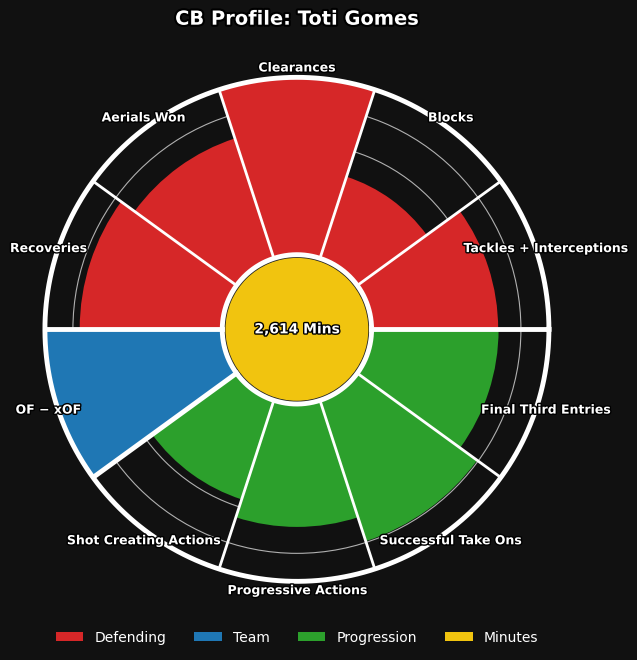

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Matt_Doherty.png


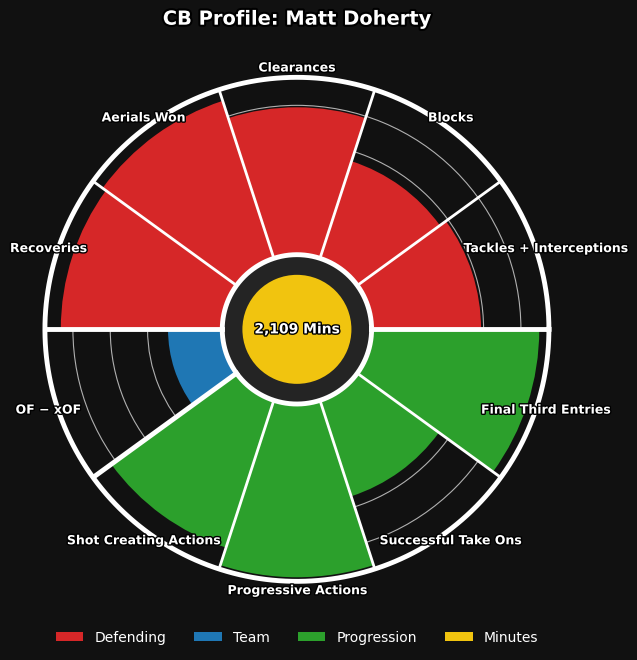

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Santiago_Bueno.png


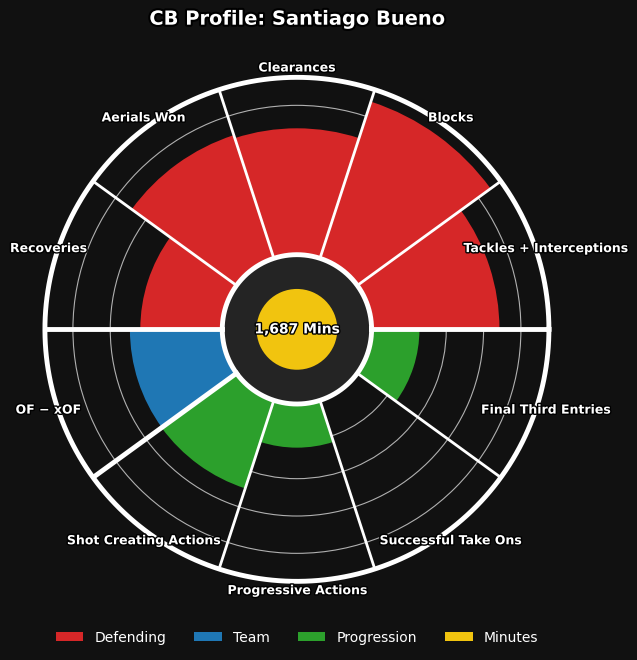

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Emmanuel_Agbadou.png


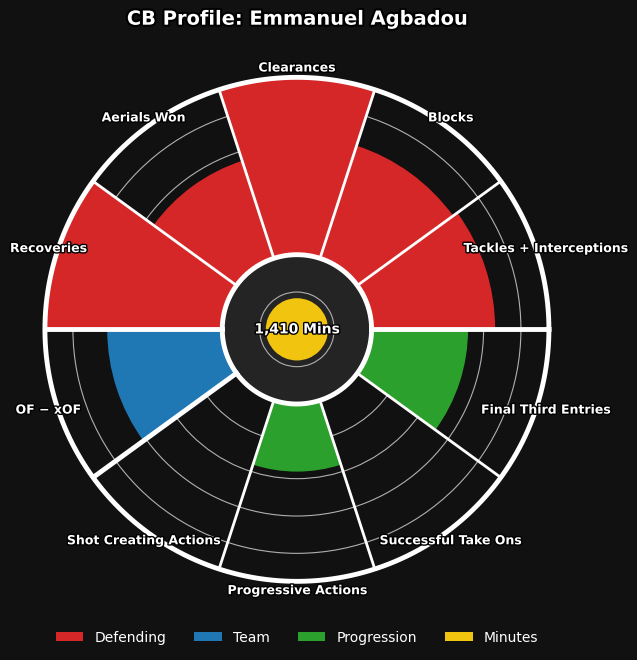

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Craig_Dawson.png


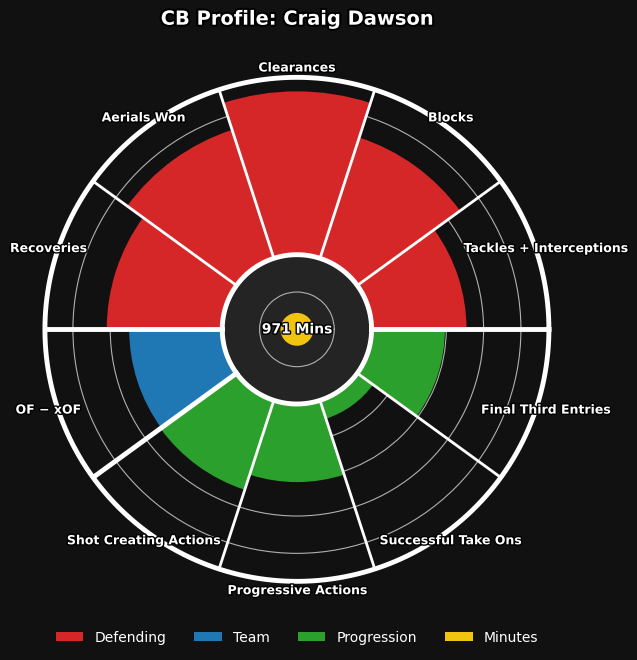

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Yerson_Mosquera.png


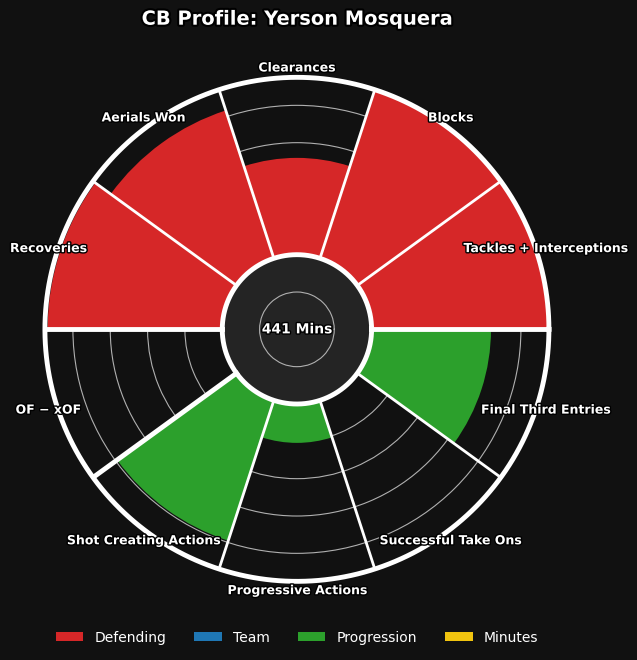

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Robert_Renan.png


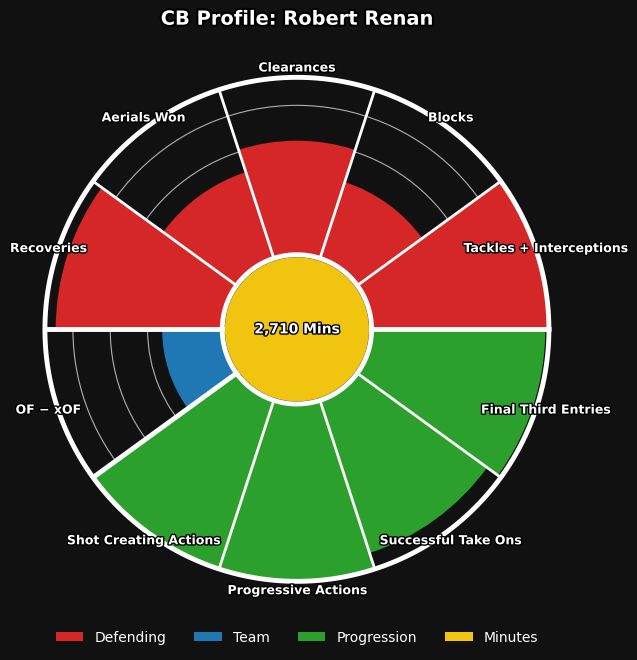

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Axel_Disasi.png


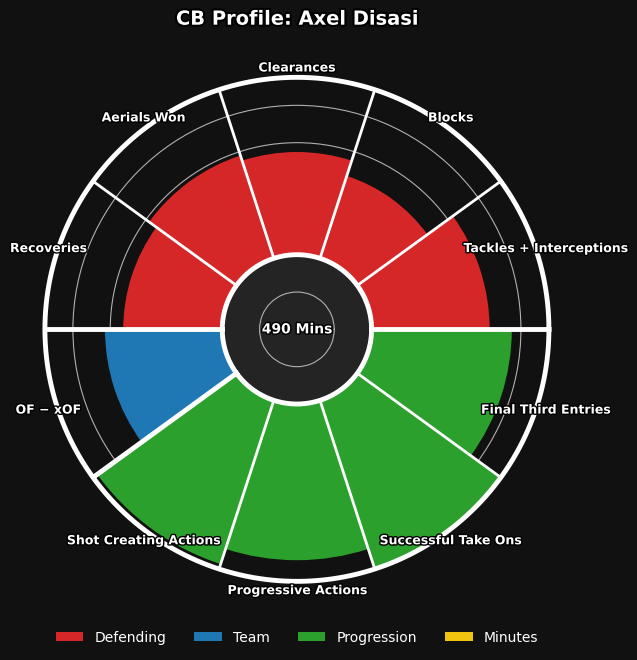

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.4/cb_donuts_dark/donut_Lloyd_Kelly.png


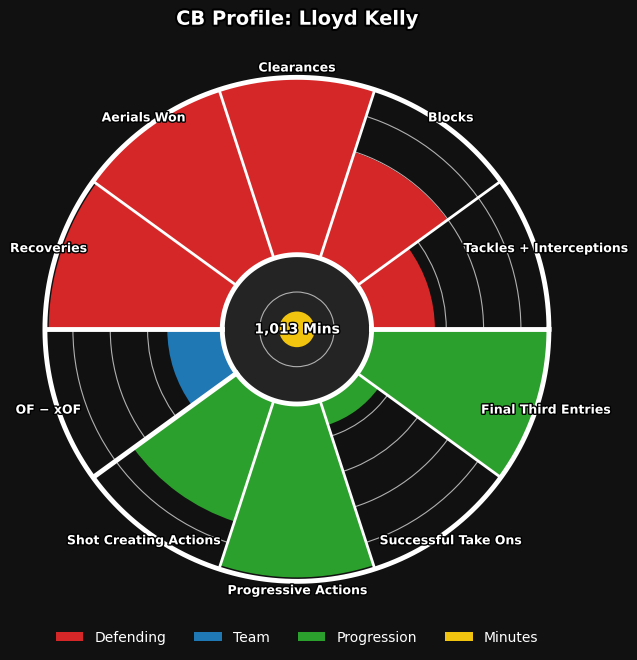

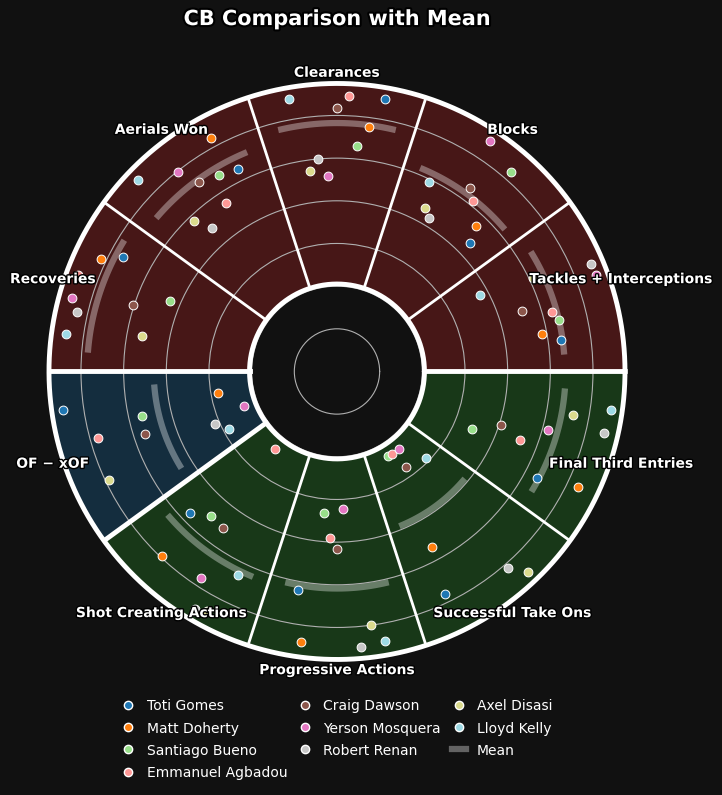

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from pathlib import Path

SHOW_PLAYER_DONUTS = True
PRINT_SAVE_MESSAGES = True
OUTPUT_DIR = Path("cb_donuts_dark")
OUTPUT_DIR.mkdir(exist_ok=True)

FILE = "wolves_standard_stats_scouted.xlsx"
df = pd.read_excel(FILE)

metrics = [
    'Tkl+Int90','Blocks90','Clear90','AW90','Recover90',  
    'OF-xOF',                                   
    'SCA90','PrgA90','STO90','1/3A90'            
]

display_names = {
    'Tkl+Int90': 'Tackles + Interceptions',
    'Blocks90': 'Blocks',
    'Clear90': 'Clearances',
    'AW90': 'Aerials Won',
    'Recover90': 'Recoveries',
    'OF-xOF': 'OF − xOF',
    'SCA90': 'Shot Creating Actions',
    'PrgA90': 'Progressive Actions',
    'STO90': 'Successful Take Ons',
    '1/3A90': 'Final Third Entries'
}

defending  = ['Tkl+Int90','Blocks90','Clear90','AW90','Recover90']
team       = ['OF-xOF']
progress   = ['SCA90','PrgA90','STO90','1/3A90']
category_order = defending + team + progress

# ====== STYLE ======
FIG_BG = AX_BG = "#111111"
DEF_COLOR  = "#d62728"
TEAM_COLOR = "#1f77b4"
PROG_COLOR = "#2ca02c"

SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.5

MIN_BG_COLOR   = "#242424"
MIN_FILL_COLOR = "#f1c40f"
MIN_TEXT_COLOR = "white"

cb_df = df[df["Position"] == "CB"].copy()
if cb_df.empty:
    print("No CB rows found in your data (Position == 'CB'). Nothing to plot.")
    raise SystemExit

players = [str(p).strip() for p in cb_df["Player"].tolist()]

def safe_p90(series):
    val = np.nanpercentile(series.astype(float), 90) if series.notna().any() else np.nan
    if pd.isna(val) or val <= 0:
        return 1.0
    return float(val)

nonneg_metrics = [m for m in metrics if m != 'OF-xOF']
p90_map = {m: safe_p90(df[m]) if m in df.columns else 1.0 for m in nonneg_metrics}

if 'OF-xOF' in df.columns:
    of_min_all = float(df['OF-xOF'].min(skipna=True))
    of_max_all = float(df['OF-xOF'].max(skipna=True))
    of_rng_all = max(1e-9, of_max_all - of_min_all)
    of_lo = float(df['OF-xOF'].quantile(0.10))
    of_hi = float(df['OF-xOF'].quantile(0.90))
    of_rng = max(1e-9, of_hi - of_lo)
else:
    of_min_all = of_rng_all = of_lo = of_rng = 1.0

norm_df_player = cb_df.copy()
for m in nonneg_metrics:
    denom = p90_map.get(m, 1.0)
    norm_df_player[m] = (cb_df[m] / denom).clip(0.0, 1.0) if m in cb_df.columns else 0.0
if 'OF-xOF' in cb_df.columns:
    norm_df_player['OF-xOF'] = ((cb_df['OF-xOF'] - of_min_all) / of_rng_all).clip(0.0, 1.0)
else:
    norm_df_player['OF-xOF'] = 0.0

norm_df_group = cb_df.copy()
for m in nonneg_metrics:
    denom = p90_map.get(m, 1.0)
    norm_df_group[m] = (cb_df[m] / denom).clip(0.0, 1.0) if m in cb_df.columns else 0.0
if 'OF-xOF' in cb_df.columns:
    norm_df_group['OF-xOF'] = ((cb_df['OF-xOF'] - of_lo) / of_rng).clip(0.0, 1.0)
else:
    norm_df_group['OF-xOF'] = 0.0

mins_series = cb_df['Min'].astype(float) if 'Min' in cb_df.columns else pd.Series([], dtype=float)
if len(mins_series) and mins_series.notna().any():
    min_lo = np.nanpercentile(mins_series, 10)
    min_hi = np.nanpercentile(mins_series, 90)
else:
    min_lo, min_hi = 0.0, 1.0
min_rng = max(1e-9, (min_hi - min_lo))

def minutes_fill_fraction(player_name):
    if 'Min' not in cb_df.columns:
        return 0.0, "Mins Unavailable"
    row = cb_df.loc[cb_df['Player'] == player_name, 'Min']
    if row.empty or pd.isna(row.iloc[0]):
        return 0.0, "Mins Unavailable"
    mins = float(row.iloc[0])
    frac = (mins - min_lo) / min_rng
    frac = float(np.clip(frac, 0.0, 1.0))
    return frac, f"{int(mins):,} Mins"

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
width = 2*np.pi / len(metrics)
inner_radius = 0.35
outer_radius = inner_radius + 1.0
theta_circle = np.linspace(0, 2*np.pi, 720)

idx_def_end  = len(defending)
idx_team_end = len(defending) + len(team)

def color_for_metric(m):
    if m in defending:  return DEF_COLOR
    if m in progress:  return PROG_COLOR
    return TEAM_COLOR

wedge_colors = [color_for_metric(m) for m in metrics]

#player
for name in players:
    row = norm_df_player.loc[norm_df_player['Player'] == name, metrics]
    if row.empty:
        print(f"Warning: No normalized row for {name}, skipping.")
        continue
    vals = np.nan_to_num(row.values.flatten().astype(float), nan=0.0)

    fig = plt.figure(figsize=(7, 7))
    fig.patch.set_facecolor(FIG_BG)
    ax = plt.subplot(111, polar=True)
    ax.set_facecolor(AX_BG)
    ax.set_ylim(0, outer_radius)

    inner_circle_radius_overlay = inner_radius + 0.05
    scale = outer_radius - inner_circle_radius_overlay

    ax.bar(0, inner_circle_radius_overlay, width=2*np.pi, bottom=0,
           color=MIN_BG_COLOR, zorder=1.5, align='edge', edgecolor=None)

    frac, mins_label = minutes_fill_fraction(name)
    r_fill = inner_circle_radius_overlay * (frac * 0.965)
    ax.bar(0, r_fill, width=2*np.pi, bottom=0,
           color=MIN_FILL_COLOR, zorder=1.6, align='edge', edgecolor=None)

    txt_m = ax.text(0.5, 0.50, mins_label,
                    transform=ax.transAxes, ha='center', va='center',
                    fontsize=10, fontweight='bold', color=MIN_TEXT_COLOR, zorder=8)
    txt_m.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

    ax.bar(angles, vals * scale, width=width, bottom=inner_circle_radius_overlay,
           align='edge', color=wedge_colors, zorder=2)

    ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])

    for ang in angles:
        ax.plot([ang, ang], [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)

    for b_idx in [0, idx_def_end, idx_team_end]:
        ax.plot([angles[b_idx], angles[b_idx]],
                [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)

    ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)

    for ang, lab in zip(angles + width/2, [display_names[m] for m in metrics]):
        txt = ax.text(ang, inner_radius + 1.05, lab,
                      ha='center', va='center', fontsize=9, fontweight='bold', color='white', zorder=6)
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])

    ax.plot(theta_circle, np.full_like(theta_circle, inner_circle_radius_overlay),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=10, clip_on=False)

    title_text = ax.set_title(f"CB Profile: {name}",
                              va='bottom', y=1.08,
                              fontsize=14, fontweight='bold', color='white')
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

    legend_handles = [
        Patch(facecolor=DEF_COLOR,  label="Defending"),
        Patch(facecolor=TEAM_COLOR, label="Team"),
        Patch(facecolor=PROG_COLOR, label="Progression"),
        Patch(facecolor=MIN_FILL_COLOR, label="Minutes"),
    ]
    leg = ax.legend(handles=legend_handles, loc='lower center',
                    bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=True)
    plt.setp(leg.get_texts(), color='white')
    leg.get_frame().set_facecolor(FIG_BG)
    leg.get_frame().set_edgecolor("none")

    plt.subplots_adjust(bottom=0.16)
    safe_name = name.strip().replace(' ', '_').replace('/', '_')
    out_path = OUTPUT_DIR / f"donut_{safe_name}.png"
    plt.savefig(out_path, dpi=200, bbox_inches="tight", facecolor=FIG_BG, pad_inches=0.25)

    if PRINT_SAVE_MESSAGES:
        print(f"Saved: {out_path.resolve()}")
    if SHOW_PLAYER_DONUTS:
        plt.show()
    else:
        plt.close(fig)

#group
group_vals = norm_df_group.set_index('Player')[metrics].fillna(0.0)
means = group_vals.mean(axis=0).values

theta_centers = angles + width/2
n_players = len(players)
ang_offsets = np.linspace(-width*0.28, width*0.28, n_players) if n_players > 1 else np.array([0.0])

LEGEND_Y   = -0.18
BOTTOM_PAD = 0.24

fig = plt.figure(figsize=(9, 9))
fig.patch.set_facecolor(FIG_BG)
ax = plt.subplot(111, polar=True)
ax.set_facecolor(AX_BG)
ax.set_ylim(0, outer_radius)

inner_circle_radius_overlay = inner_radius + 0.06
annulus_height = outer_radius - inner_circle_radius_overlay
scale = annulus_height
eps = 0.004

dot_inner_pad = 0.05
dot_outer_pad = 0.05
dot_base  = inner_circle_radius_overlay + dot_inner_pad
dot_span  = annulus_height - (dot_inner_pad + dot_outer_pad)

ax.bar(angles, np.full(len(metrics), annulus_height), width=width,
       bottom=inner_circle_radius_overlay, align='edge',
       color=wedge_colors, alpha=0.28, zorder=1, edgecolor=None)

for ang in angles:
    ax.plot([ang, ang], [inner_circle_radius_overlay, outer_radius],
            linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)

for b_idx in [0, idx_def_end, idx_team_end]:
    ax.plot([angles[b_idx], angles[b_idx]],
            [inner_circle_radius_overlay, outer_radius],
            linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)

mean_arc_half = width * 0.36
for i, mu in enumerate(means):
    r_mu = inner_circle_radius_overlay + float(mu) * scale
    thetas = np.linspace(theta_centers[i] - mean_arc_half, theta_centers[i] + mean_arc_half, 80)
    ax.plot(thetas, np.full_like(thetas, r_mu),
            color=SEPARATOR_COLOR, linewidth=4.5, alpha=0.35, zorder=6, clip_on=False)

ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
        color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=7, clip_on=False)

import matplotlib as mpl
cmap = mpl.colormaps.get_cmap('tab20').resampled(max(1, n_players))
player_colors = {p: cmap(i) for i, p in enumerate(players)}

for j, p in enumerate(players):
    vals = group_vals.loc[p].values
    thetas = theta_centers + ang_offsets[j]
    rs = dot_base + vals * dot_span
    rs = np.clip(rs, dot_base + eps,
                 inner_circle_radius_overlay + annulus_height - dot_outer_pad - eps)
    ax.scatter(thetas, rs, s=40, color=player_colors[p],
               edgecolor='white', linewidth=0.7, zorder=7.5, label=p, clip_on=False)

for ang, lab in zip(theta_centers, [display_names[m] for m in metrics]):
    txt = ax.text(ang, inner_radius + 1.05, lab,
                  ha='center', va='center', fontsize=10, fontweight='bold', color='white', zorder=8)
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

ax.plot(theta_circle, np.full_like(theta_circle, inner_circle_radius_overlay),
        color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=10, clip_on=False)

title_text = ax.set_title("CB Comparison with Mean",
                          va='bottom', y=1.08,
                          fontsize=15, fontweight='bold', color='white')
title_text.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground='black'),
    path_effects.Normal()
])

ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])

player_handles = [
    Line2D([0], [0], marker='o', linestyle='', markersize=6,
           markerfacecolor=player_colors[p], markeredgecolor='white', label=p)
    for p in players
]
mean_handle = Line2D([0], [0], color=SEPARATOR_COLOR, lw=4.5, alpha=0.35, label="Mean")
handles = player_handles + [mean_handle]
labels = players + ["Mean"]

leg = ax.legend(handles, labels, loc='lower center',
                bbox_to_anchor=(0.5, LEGEND_Y - 0.05),
                ncol=min(6, max(3, int(np.ceil(len(players) / 3)))),
                frameon=True, handlelength=1.0, columnspacing=0.8, labelspacing=0.6)
plt.setp(leg.get_texts(), color='white')
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

plt.subplots_adjust(bottom=BOTTOM_PAD)
plt.show()


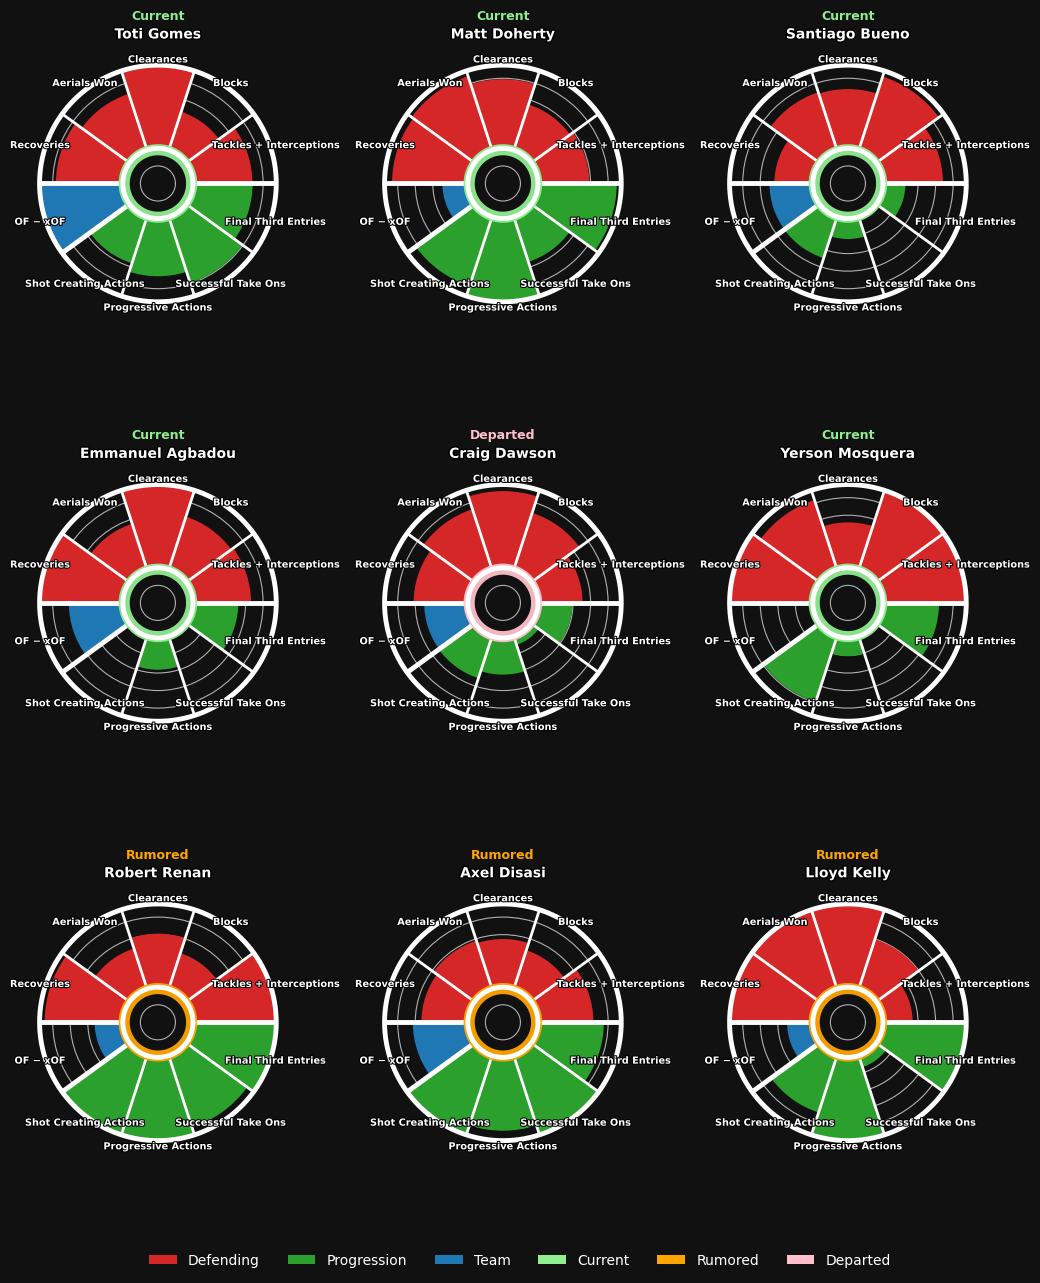

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

FILE = "wolves_standard_stats_scouted.xlsx"
df = pd.read_excel(FILE)

metrics = [
    'Tkl+Int90','Blocks90','Clear90','AW90','Recover90',   
    'OF-xOF',                                           
    'SCA90','PrgA90','STO90','1/3A90'                   
]

display_names = {
    'Tkl+Int90': 'Tackles + Interceptions',
    'Blocks90': 'Blocks',
    'Clear90': 'Clearances',
    'AW90': 'Aerials Won',
    'Recover90': 'Recoveries',
    'OF-xOF': 'OF − xOF',
    'SCA90': 'Shot Creating Actions',
    'PrgA90': 'Progressive Actions',
    'STO90': 'Successful Take Ons',
    '1/3A90': 'Final Third Entries'
}

defending  = ['Tkl+Int90','Blocks90','Clear90','AW90','Recover90']
team       = ['OF-xOF']
progress   = ['SCA90','PrgA90','STO90','1/3A90']

DEF_COLOR  = "#d62728"
PROG_COLOR = "#2ca02c"
TEAM_COLOR = "#1f77b4"

def color_for_metric(m):
    if m in defending: return DEF_COLOR
    if m in progress:  return PROG_COLOR
    return TEAM_COLOR
wedge_colors = [color_for_metric(m) for m in metrics]

FIG_BG = AX_BG = "#111111"
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.5

cb_df = df[df["Position"] == "CB"].copy()
players = cb_df["Player"].astype(str).tolist()
if len(players) == 0:
    print("No CB rows found (Position == 'CB').")
    raise SystemExit

nonneg_metrics = [m for m in metrics if m != 'OF-xOF']
p90 = df[nonneg_metrics].quantile(0.90).replace(0, np.nan)

if 'OF-xOF' in df.columns:
    of_min_all = df['OF-xOF'].min()
    of_max_all = df['OF-xOF'].max()
    of_rng_all = max(1e-9, of_max_all - of_min_all)
else:
    of_min_all, of_rng_all = 0.0, 1.0

norm_df = cb_df.copy()
for m in nonneg_metrics:
    denom = p90.get(m, np.nan)
    denom = 1.0 if (pd.isna(denom) or denom <= 0) else float(denom)
    norm_df[m] = (cb_df[m] / denom).clip(0.0, 1.0) if m in cb_df.columns else 0.0

if 'OF-xOF' in cb_df.columns:
    norm_df['OF-xOF'] = ((cb_df['OF-xOF'] - of_min_all) / of_rng_all).clip(0.0, 1.0)
else:
    norm_df['OF-xOF'] = 0.0

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
width = 2*np.pi / len(metrics)
inner_radius = 0.35
outer_radius = inner_radius + 1.0
theta_circle = np.linspace(0, 2*np.pi, 720)

idx_def_end  = len(defending)
idx_team_end = len(defending) + len(team)

STATUS_COLORS = {"Current": "lightgreen", "Rumored": "orange", "Departed": "pink"}
status_raw = cb_df["Status"].fillna("").astype(str).str.strip().str.lower()

def _status_label(s):
    if s == "left": return "Departed"
    if s == "rumor": return "Rumored"
    return "Current"

status_labels = status_raw.map(_status_label)
status_by_player = dict(zip(cb_df["Player"], status_labels))
status_colors_by_player = {p: STATUS_COLORS[status_by_player[p]] for p in players}

n_players = len(players)
ncols = 3
nrows = int(np.ceil(n_players / ncols))

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, subplot_kw=dict(polar=True),
    figsize=(ncols * 3.5, nrows * 4.5)
)
axs = axs.flatten()

for i, name in enumerate(players):
    vals = norm_df.loc[norm_df['Player'] == name, metrics].values.flatten()
    vals = np.nan_to_num(vals, nan=0.0)

    ax = axs[i]
    ax.set_facecolor(AX_BG)
    ax.set_ylim(0, outer_radius)

    inner_circle_radius_overlay = inner_radius + 0.05
    scale = outer_radius - inner_circle_radius_overlay

    ax.bar(
        angles, vals * scale, width=width, bottom=inner_circle_radius_overlay,
        align='edge', color=wedge_colors, zorder=2
    )

    for ang in angles:
        ax.plot([ang, ang], [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THIN, color=SEPARATOR_COLOR, zorder=3, solid_capstyle='butt')

    for b_idx in [0, idx_def_end, idx_team_end]:
        b_ang = angles[b_idx]
        ax.plot([b_ang, b_ang], [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THICK, color=SEPARATOR_COLOR, zorder=4, solid_capstyle='butt')

    ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=5, clip_on=False, solid_capstyle='butt')

    for ang, lab in zip(angles + width/2, [display_names[m] for m in metrics]):
        txt = ax.text(
            ang, inner_radius + 1.065, lab,
            rotation=0, ha='center', va='center',
            fontsize=7, fontweight='bold', color='white', zorder=6
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()
        ])

    status_ring_r = inner_radius + 0.035
    ax.plot(theta_circle, np.full_like(theta_circle, status_ring_r),
            color=status_colors_by_player[name], linewidth=8, zorder=9, solid_capstyle='butt', alpha=0.95)

    ax.plot(theta_circle, np.full_like(theta_circle, inner_circle_radius_overlay),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=10, clip_on=False, solid_capstyle='butt')

    ax.text(0.5, 1.18, status_by_player[name],
            transform=ax.transAxes, ha='center', va='bottom',
            fontsize=9, fontweight='bold', color=status_colors_by_player[name])
    title_text = ax.text(
        0.5, 1.10, name,
        transform=ax.transAxes, ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='white'
    )
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

    ax.set_xticks([])
    ax.set_thetagrids([])
    ax.set_yticklabels([])

last_used = len(players) - 1
for j in range(last_used + 1, len(axs)):
    axs[j].axis('off')

fig.patch.set_facecolor(FIG_BG)

legend_handles = [
    Patch(facecolor=DEF_COLOR,  label="Defending"),
    Patch(facecolor=PROG_COLOR, label="Progression"),
    Patch(facecolor=TEAM_COLOR, label="Team"),
    Patch(facecolor=STATUS_COLORS["Current"],  label="Current"),
    Patch(facecolor=STATUS_COLORS["Rumored"],  label="Rumored"),
    Patch(facecolor=STATUS_COLORS["Departed"], label="Departed"),
]
leg = fig.legend(
    handles=legend_handles, loc='lower center', ncol=6,
    bbox_to_anchor=(0.5, 0.02), frameon=True
)
plt.setp(leg.get_texts(), color='white')
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

plt.tight_layout(rect=[0, 0.06, 1, 1], h_pad=3.0)
plt.show()


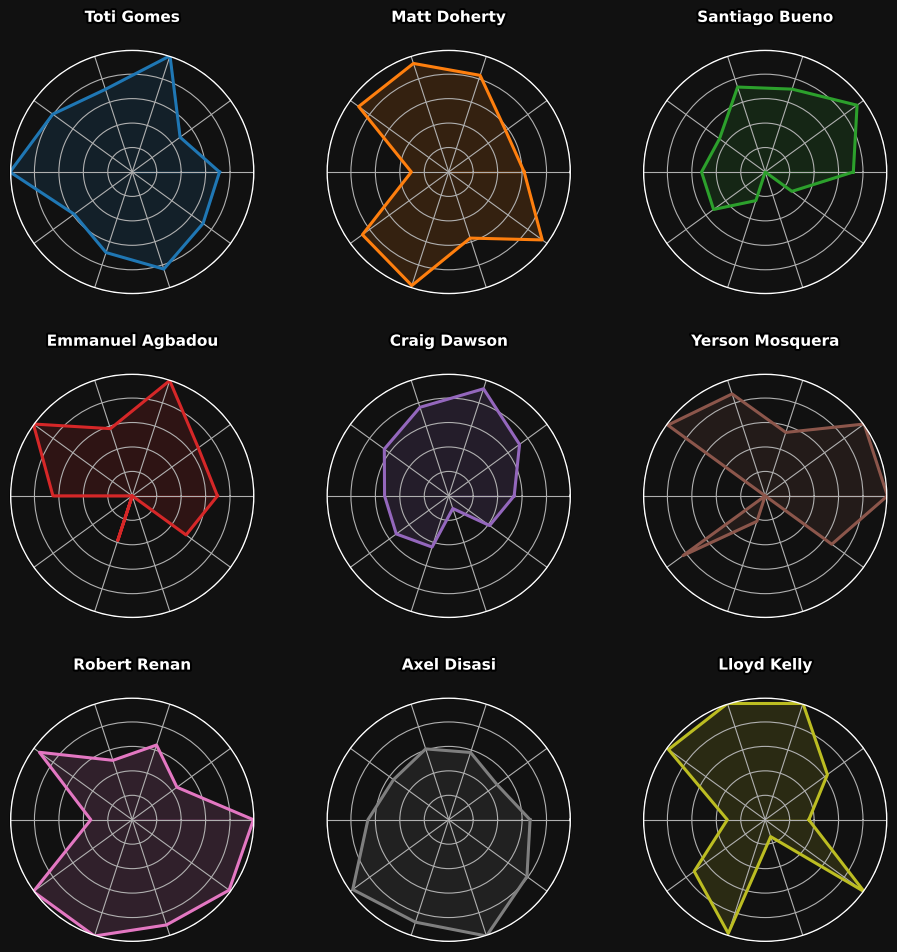

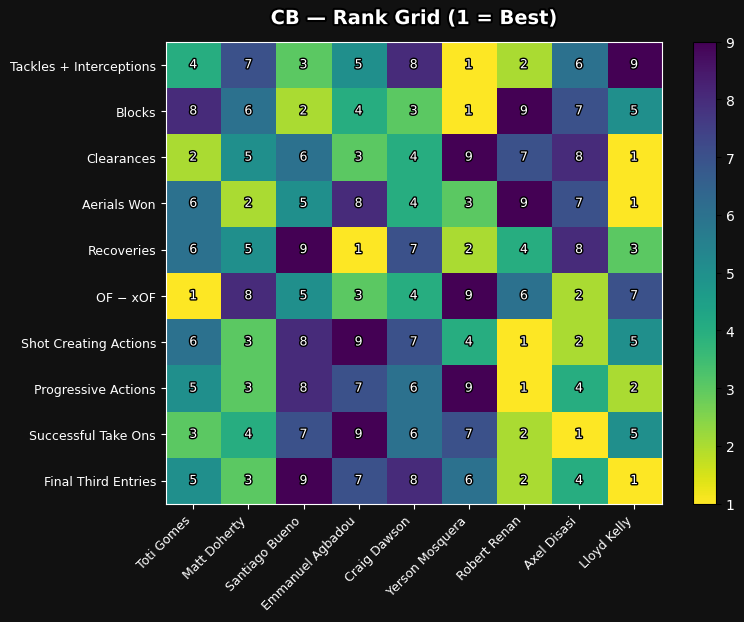

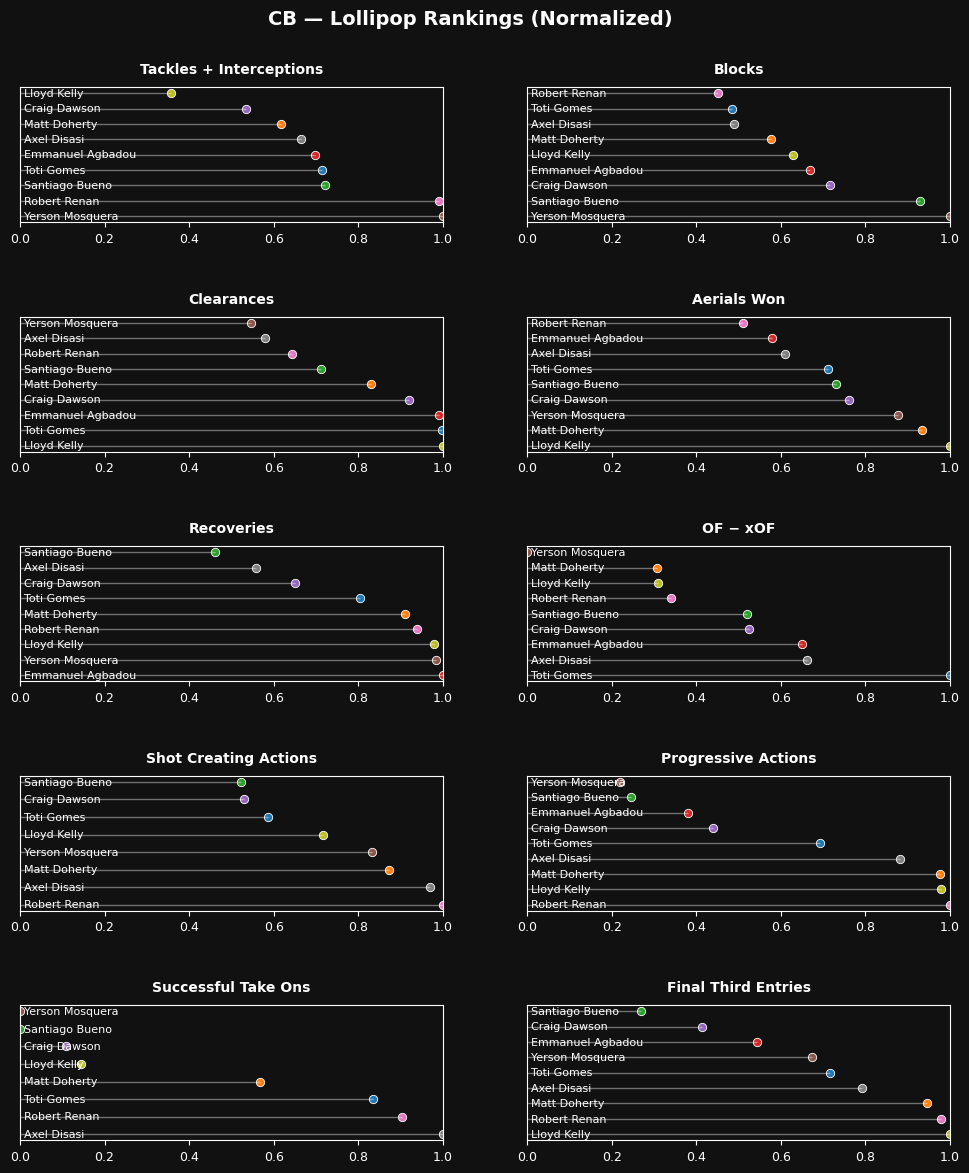

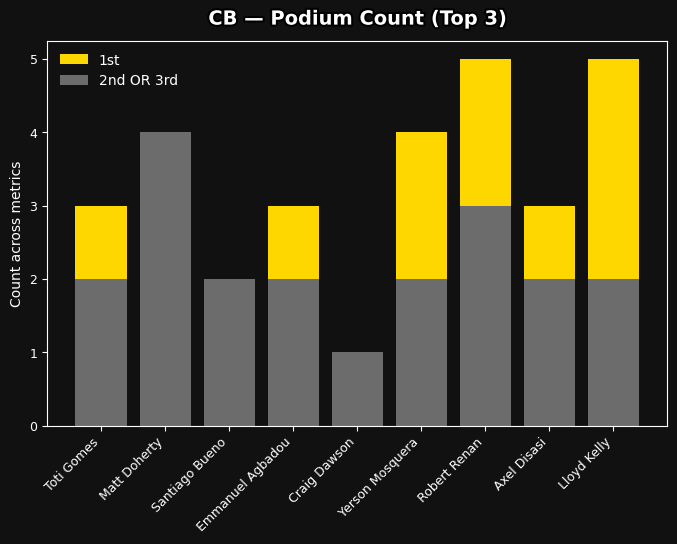

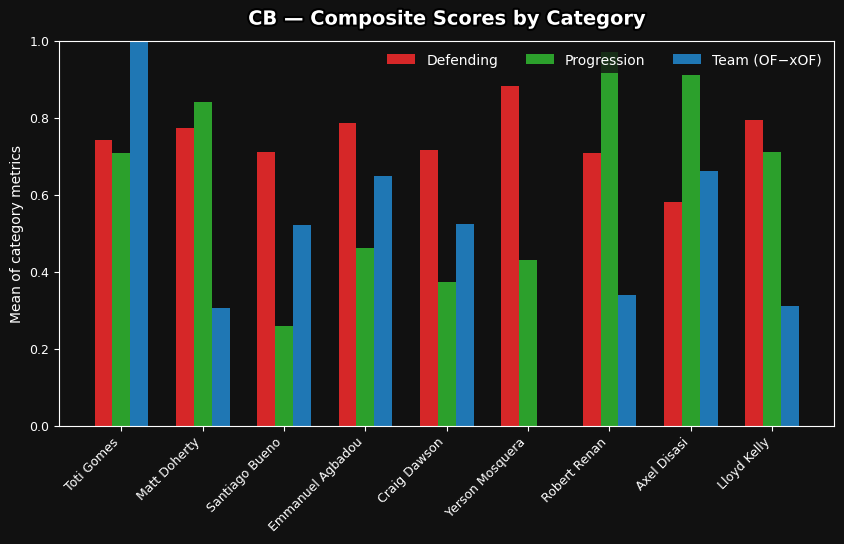

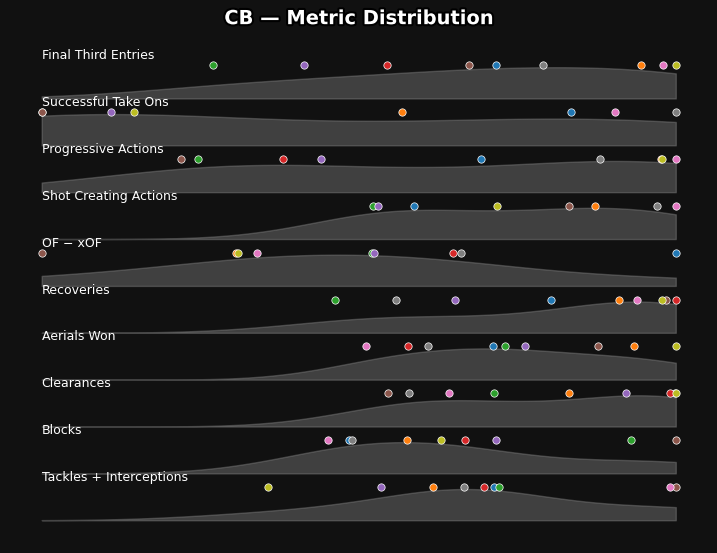

In [5]:
# ===================================
# FULLY-STYLED CB VIS TOOLKIT (DARK)
# ===================================
# IMPORTANT (expected from your CB prep):
#   - norm_df  (CB-only, normalized 0–1 with safe scaling for OF-xOF)
#   - metrics, display_names, players
#   - FIG_BG, AX_BG
#   - DEF_COLOR, PROG_COLOR, TEAM_COLOR
#
# This toolkit mirrors your CAM version but adapted to CB categories and
# adds robust NaN/inf handling so ranking/plotting won't crash.

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from collections import defaultdict

# ---- category definitions for CB ----
defending  = ['Tkl+Int90','Blocks90','Clear90','AW90','Recover90']
team       = ['OF-xOF']  # may be negative before normalization; here already 0–1
progress   = ['SCA90','PrgA90','STO90','1/3A90']

# ---------- helpers ----------
def _dark_fig_ax(size=(7,7)):
    fig = plt.figure(figsize=size)
    fig.patch.set_facecolor(FIG_BG)
    ax = plt.subplot(111)
    ax.set_facecolor(AX_BG)
    return fig, ax

def _style_axes(ax):
    ax.tick_params(colors='white', labelsize=9)
    for spine in ax.spines.values():
        spine.set_color('white')

def _title(ax, text, y=1.02, size=14):
    t = ax.set_title(text, color='white', fontsize=size, fontweight='bold', y=y)
    t.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

def _save(fig, name=None, pad=0.3):
    # If you also want files, uncomment the next line:
    # fig.savefig(name, dpi=200, bbox_inches="tight", facecolor=FIG_BG, pad_inches=pad)
    plt.show()
    plt.close(fig)

def _names_for_metrics(mets):
    return [display_names[m] for m in mets]

# Category composites (rows=players)
def _category_composites(M):
    D = M[defending].mean(axis=1, skipna=True) if set(defending).issubset(M.columns) else None
    G = M[team].mean(axis=1,      skipna=True) if set(team).issubset(M.columns)      else None  # team = OF-xOF
    P = M[progress].mean(axis=1,  skipna=True) if set(progress).issubset(M.columns)  else None
    return D, G, P

# Z-score per column (NaN-safe; NaNs stay NaN)
def _zscore(M):
    mu = M.mean(axis=0, skipna=True)
    sd = M.std(axis=0, ddof=0, skipna=True).replace(0, 1)
    return (M - mu) / sd

# consistent player color map
player_cmap = {p: plt.cm.tab10(i % 10) for i,p in enumerate(players)}

# Base matrices (players x metrics)
# M keeps NaNs for ranking logic; M_plot is NaN/inf-free for plotting
M = (
    norm_df.set_index('Player')[metrics]
    .reindex(players)
)
M = M.replace([np.inf, -np.inf], np.nan)

M_plot = M.fillna(0.0)

# ============================================
# 1) Z-score heatmap (players x metrics)
# ============================================
def vis_heatmap_zscore():
    mat = _zscore(M.copy()).fillna(0.0)  # show blanks as 0 for color mapping
    fig, ax = _dark_fig_ax((7,7))
    im = ax.imshow(mat.values, aspect='auto', cmap='coolwarm', vmin=-2.5, vmax=2.5)
    ax.set_yticks(range(len(players)))
    ax.set_yticklabels(players, color='white', fontsize=9)
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(_names_for_metrics(metrics), rotation=45, ha='right', color='white', fontsize=8)
    _style_axes(ax)
    _title(ax, "CB — Metric Heatmap (z-score)")
    cbar = fig.colorbar(im)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    _save(fig, "cb_heatmap_zscore.png")

# ============================================
# 2) Beeswarm / strip by metric
# ============================================
def vis_beeswarm():
    fig, ax = _dark_fig_ax((7,7))
    y_positions = np.arange(len(metrics))
    for i, m in enumerate(metrics):
        xs = M[m].values
        finite = np.isfinite(xs)
        xs = xs[finite]
        pls = np.array(players)[finite]
        y = np.full_like(xs, y_positions[i], dtype=float) + (np.random.rand(len(xs))-0.5) * 0.25
        for x, yy, p in zip(xs, y, pls):
            ax.scatter(x, yy, s=36, color=player_cmap[p], edgecolor='white', linewidth=0.6, zorder=2)
    # means (skip NaNs)
    means = M.mean(axis=0, skipna=True).values
    ax.scatter(means, y_positions, s=80, facecolors='none', edgecolor='white', linewidth=1.4, zorder=3)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(_names_for_metrics(metrics), color='white', fontsize=9)
    ax.set_xlabel("Normalized value (0–1)", color='white')
    _style_axes(ax)
    _title(ax, "CB — Beeswarm by Metric (w/ means)")
    _save(fig, "cb_beeswarm.png")

# ============================================
# 5) Radar small multiples (grid)
# ============================================
def vis_radar_small_multiples():
    n = len(players)
    cols = 3
    rows = math.ceil(n/cols)
    fig = plt.figure(figsize=(cols*3.2, rows*3.2))
    fig.patch.set_facecolor(FIG_BG)
    angles_p = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    th = np.linspace(0, 2*np.pi, 720)
    for i, p in enumerate(players, 1):
        ax = plt.subplot(rows, cols, i, polar=True)
        ax.set_facecolor(AX_BG); ax.set_ylim(0,1)
        vals = M_plot.loc[p].values  # NaNs→0
        ax.plot(np.append(angles_p, angles_p[0]), np.append(vals, vals[0]), color=player_cmap[p], linewidth=2.2)
        ax.fill_between(np.append(angles_p, angles_p[0]), 0, np.append(vals, vals[0]),
                        color=player_cmap[p], alpha=0.15)
        ax.set_xticks(angles_p); ax.set_yticklabels([]); ax.set_xticklabels([])
        ax.plot(th, np.full_like(th, 0), color='white', lw=3.5, alpha=1.0, zorder=5)
        ax.plot(th, np.full_like(th, 1), color='white', lw=2.0, alpha=1.0, zorder=5)
        t = ax.set_title(p, color='white', fontsize=11, y=1.08, fontweight='bold')
        t.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    plt.tight_layout(h_pad=3.0, w_pad=1.5)  # more vertical gap, slight horizontal gap
    _save(fig, "cb_radar_small_multiples.png", pad=0.2)


# ============================================
# 8) Rank grid (metric x player, numbers)
# ============================================
def vis_rank_grid():
    # Rank each metric column; NaNs get worst rank (= len(players))
    ranks = M.copy()
    for m in metrics:
        col = M[m]
        r = col.rank(ascending=False, method='min', na_option='bottom')  # put NaNs at bottom if supported
        # For pandas versions without DataFrame.rank na_option, fall back to Series logic:
        if r.isna().any():
            r = r.fillna(len(players))
        ranks[m] = r.astype(int)

    fig, ax = _dark_fig_ax((8,6))
    im = ax.imshow(ranks.values.T, aspect='auto', cmap='viridis_r')
    ax.set_yticks(range(len(metrics)))
    ax.set_yticklabels(_names_for_metrics(metrics), color='white', fontsize=9)
    ax.set_xticks(range(len(players)))
    ax.set_xticklabels(players, rotation=45, ha='right', color='white', fontsize=8)

    for i in range(len(players)):
        for j in range(len(metrics)):
            val = int(ranks.values[i, j])
            txt = ax.text(i, j, str(val), ha='center', va='center',
                          color='white', fontsize=9, zorder=3)
            txt.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
    _style_axes(ax)
    _title(ax, "CB — Rank Grid (1 = Best)")
    cbar = fig.colorbar(im)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    _save(fig, "cb_rank_grid.png")

# ============================================
# 9) Lollipop ranks per metric (multi-panel)
# ============================================
def vis_lollipop_ranks():
    r, c = 5, 2
    pages = math.ceil(len(metrics)/(r*c))
    for page in range(pages):
        fig = plt.figure(figsize=(c*6, r*2.6))
        fig.patch.set_facecolor(FIG_BG)
        for k in range(r*c):
            idx = page*(r*c)+k
            if idx >= len(metrics): break
            m = metrics[idx]
            ax = plt.subplot(r, c, k+1)
            ax.set_facecolor(AX_BG)

            s = M[m].dropna().sort_values(ascending=False)  # drop NaNs for clean order
            ax.hlines(y=np.arange(len(s)), xmin=0, xmax=s.values, color='white', lw=1, alpha=0.4)
            for i,(p,val) in enumerate(s.items()):
                ax.scatter(val, i, s=36, color=player_cmap[p], edgecolor='white', linewidth=0.6)
                ax.text(0.01, i, p, va='center', color='white', fontsize=8)
            ax.set_yticks([])
            ax.set_xlim(0,1)
            ax.set_title(display_names[m], color='white', fontsize=10, fontweight='bold', pad=10)
            _style_axes(ax)
        fig.suptitle("CB — Lollipop Rankings (Normalized)", y=0.98, color='white', fontsize=14, fontweight='bold')
        plt.subplots_adjust(top=0.92, hspace=0.7)
        _save(fig, f"cb_lollipop_ranks_p{page+1}.png", pad=0.3)

# ============================================
# 10) Medal table (top1/top3 counts)
# ============================================
def vis_medal_table():
    counts_top1 = defaultdict(int)
    counts_top3 = defaultdict(int)
    for m in metrics:
        s = M[m].dropna().sort_values(ascending=False)
        if s.empty:
            continue
        counts_top1[s.index[0]] += 1
        for p in s.index[:3]:
            counts_top3[p] += 1

    fig, ax = _dark_fig_ax((8,5))
    x = np.arange(len(players))
    top1_list = np.array([counts_top1[p] for p in players])
    top3_list = np.array([counts_top3[p] for p in players])
    top3_only = top3_list - top1_list

    ax.bar(x, top1_list, bottom=top3_only, color="#ffd700", label="1st")
    ax.bar(x, top3_only, color="#aaaaaa", alpha=0.6, label="2nd OR 3rd")
    ax.set_xticks(x); ax.set_xticklabels(players, rotation=45, ha='right', color='white')
    ax.set_ylabel("Count across metrics", color='white')
    _style_axes(ax); _title(ax, "CB — Podium Count (Top 3)")
    leg = ax.legend(frameon=True)
    for txt in leg.get_texts(): txt.set_color('white')
    leg.get_frame().set_facecolor(FIG_BG); leg.get_frame().set_edgecolor("none")
    _save(fig, "cb_medal_table.png")

# ============================================
# 13) Composite score bars (by category)
# ============================================
def vis_composite_bars():
    D, G, P = _category_composites(M)
    fig, ax = _dark_fig_ax((10,5))
    x = np.arange(len(players))
    w = 0.22

    # graceful fallbacks if any category missing
    Dv = (D.values if hasattr(D, 'values') else np.zeros(len(players))) if D is not None else np.zeros(len(players))
    Gv = (G.values if hasattr(G, 'values') else np.zeros(len(players))) if G is not None else np.zeros(len(players))
    Pv = (P.values if hasattr(P, 'values') else np.zeros(len(players))) if P is not None else np.zeros(len(players))

    ax.bar(x - w, Dv, width=w, color=DEF_COLOR,  label="Defending")
    ax.bar(x,     Pv, width=w, color=PROG_COLOR, label="Progression")
    ax.bar(x + w, Gv, width=w, color=TEAM_COLOR, label="Team (OF−xOF)")

    ax.set_xticks(x); ax.set_xticklabels(players, rotation=45, ha='right', color='white')
    ax.set_ylim(0,1); ax.set_ylabel("Mean of category metrics", color='white')
    _style_axes(ax); _title(ax, "CB — Composite Scores by Category")
    leg = ax.legend(frameon=True, ncol=3)
    for txt in leg.get_texts(): txt.set_color('white')
    leg.get_frame().set_facecolor(FIG_BG); leg.get_frame().set_edgecolor("none")
    _save(fig, "cb_composite_bars.png")

# ============================================
# 18) Metric ridge-like density (approx — small N)
# ============================================
def vis_ridgeline_like():
    try:
        from scipy.stats import gaussian_kde
    except Exception:
        print("scipy not available — skipping ridgeline-like.")
        return
    rows = len(metrics)
    fig, ax = _dark_fig_ax((9, rows*0.45 + 2))
    ax.set_axis_off()
    x = np.linspace(0,1,256)
    base_y = 0
    gap = 1.2
    for i, m in enumerate(metrics):
        vals = M[m].dropna().values
        # KDE can fail with <=1 unique value; handle safely:
        if len(vals) < 2 or len(np.unique(vals)) < 2:
            y = np.zeros_like(x)
        else:
            kde = gaussian_kde(vals, bw_method='scott')
            y = kde(x)
            if y.max() > 0:
                y = y / y.max()
        y = y*0.8
        ax.fill_between(x, base_y, base_y + y, color="#888888", alpha=0.4)

        # Scatter each player's value if present
        for p in players:
            v = M.at[p, m]
            if np.isfinite(v):
                ax.scatter(v, base_y + 0.85, s=28, color=player_cmap[p], edgecolor='white', linewidth=0.5, zorder=3)

        ax.text(0.0, base_y + 0.95, display_names[m], color='white', fontsize=9, va='bottom')
        base_y += gap
    _title(ax, "CB — Metric Distribution", y=1.02)
    _save(fig, "cb_ridgeline_like.png", pad=0.2)

# =========================
# RUN EVERYTHING (CB)
# =========================
def run_all_cb_visuals():
    # vis_heatmap_zscore()
    # vis_beeswarm()
    vis_radar_small_multiples()
    vis_rank_grid()
    vis_lollipop_ranks()
    vis_medal_table()
    vis_composite_bars()
    vis_ridgeline_like()

# call this to generate everything:
run_all_cb_visuals()
